# 深層学習APIで学習機の実装を加速させる

__目次__

- <a href="#AD_bg">自動微分について</a>
  - <a href="#AD_bg_forwardone">フォワードモード（1変数の例）</a>
  - <a href="#AD_bg_forwardmulti">フォワードモード（多変数の例）</a>
  - <a href="#AD_bg_reverse">リバースモード</a>
- <a href="#NN_bg">ニューラルネットワークと逆伝播法</a>
- <a href="#chainer_bg">Chainerを使ってみよう</a>
  - <a href="#chainer_exSimple">簡単な計算</a>
  - <a href="#chainer_linreg">線形回帰での最小二乗法を再現</a>
  - <a href="#chainer_exNonLin">任意の活性化関数を用いた非線形モデル</a>
  - <a href="#chainer_lgstreg">多クラスのロジスティック回帰の自作と比較</a>
  - <a href="#chainer_newopt">最適化と自分の手で</a>

___

<a id="AD_bg"></a>
## 自動微分について

一言でいうと、自動微分（automatic differentiation, AD）とは、連鎖律を巧妙に繰り返して使うことで、合成関数の微分計算を実装する多種の手法のことである。まず重要なことを述べておくと、

- 数式処理も近似もせず、合成関数のパーツから解析的に求める。

- 代表的なものとしてボトムアップ型もトップダウン型もあって、扱っている関数の入力と出力それぞれの数によって、どれが効率的かが違ってくる。

さて、簡単な事例から見ていこう。

<a id="AD_bg_forwardone"></a>
### フォワードモード（1変数の例）

まずは一変数の関数からなる単純な合成関数を例として取り上げて、ボトムアップ型の方法を見ていくことにする。

関数$f(g(h(x)))$を考える。

これらの$f,g,h$が$\mathbb{R}$の上で微分可能で、実数値を返す関数とする。

やりたいこと：$x$について、$f(g(h(x)))$の微分を求めたい（導関数の取る値を計算したい）。

次の表現を使うと便利である。

\begin{align*}
u_{0} & = x\\
u_{1} & = h(u_{0})\\
u_{2} & = g(u_{1})\\
u_{3} & = f(u_{2}).
\end{align*}

連鎖律を何度か使うと、以下のように展開できる。

\begin{align*}
\frac{d u_{3}}{d x} & = \left(\frac{d u_{3}}{d u_{2}}\frac{d u_{2}}{d x}\right)\\
& = \frac{d u_{3}}{d u_{2}}\left(\frac{d u_{2}}{d u_{1}}\frac{d u_{1}}{d x}\right)\\
& = \frac{d u_{3}}{d u_{2}}\frac{d u_{2}}{d u_{1}} \left(\frac{d u_{1}}{d u_{0}}\frac{d u_{0}}{d x}\right).
\end{align*}

括弧の中にあるところに注視しながら、「層」ごとに入力$x$についての微分を次のように定義する。

\begin{align*}
\dot{u}_{i} = \frac{d u_{i}}{d x}, \quad i = 0,1,\ldots,3
\end{align*}

明らかな通り、「下層」から始めると、次のように全層分を再帰的に計算できる。

\begin{align*}
\dot{u}_{i} = \frac{d u_{i}}{d u_{i-1}} \dot{u}_{i-1}.
\end{align*}

フォワードモードの自動微分のアルゴリズムをざっくりまとめると次の通りである。

0. シードたる$\dot{u}_{0}$を計算しておく（普通は$\dot{u}_{0}=1$）

0. 以降、$i=1,2,\ldots$に対して：
   0. $d u_{i} / d u_{i-1}$を計算
   0. $\dot{u}_{i-1}$を用いて、$\dot{u}_{i}$を計算

上記の通りに、有限個の計算を経て、$d f(g(h(x))) / dx$を正しく計算することができる。

<a id="AD_bg_forwardmulti"></a>
### フォワードモード（多変数の例）

次は多変数への拡張を考える。

\begin{align*}
\mathbf{x} \in \mathbb{R}^{d_{0}}, \enspace h:\mathbb{R}^{d_{0}} \to \mathbb{R}^{d_{1}}, \enspace g:\mathbb{R}^{d_{1}} \to \mathbb{R}^{d_{2}}, \enspace f:\mathbb{R}^{d_{2}} \to \mathbb{R}^{d_{3}}\end{align*}

先ほどと同様に、いくつかの層に分けて、その入出力をベクトル表記すると以下のようになる。

\begin{align*}
\mathbf{u}_{0} & = \mathbf{x}\\
\mathbf{u}_{1} & = h(\mathbf{u}_{0})\\
\mathbf{u}_{2} & = g(\mathbf{u}_{1})\\
\mathbf{u}_{3} & = f(\mathbf{u}_{2}).
\end{align*}

流れは特に変わらないが、ここでは通常の微分ではなく、__偏微分__である。偏微分をたくさん整列させたヤコビ行列が基本となる。

入力を$\mathbf{x} = (x_{1},\ldots,x_{d_{0}})$、各層の出力を$\mathbf{u}_{i}=(u_{i,1},\ldots,u_{i,d_{i}})$と書く。次のように各層の出力を下層の入力について微分したヤコビ行列を表わす。

\begin{align*}
\dot{U}_{i} = \left[ \frac{\partial u_{i,j}}{\partial x_{k}} \right]_{j,k},
\end{align*}

この行列の形は$(d_{i} \times d_{0})$である。

前節の肝ともいえる再帰的な演算をここで多次元へと拡張する。

\begin{align*}
\frac{\partial u_{i,j}}{\partial x_{k}} = \sum_{l=1}^{d_{i-1}} \frac{\partial u_{i,j}}{\partial u_{i-1,l}} \frac{\partial u_{i-1,l}}{\partial x_{k}}
\end{align*}

これは各$i=1,2\ldots$と$j \in [d_{i}]$に対して定義されている。

各層の入出力だけで出来上がる$(d_{i} \times d_{i-1})$ヤコビ行列もある。

\begin{align*}
J_{i} = \left[\frac{\partial u_{i,j}}{\partial u_{i-1,k}}\right]_{j,k},
\end{align*}

この2つをかけておくと、行列の掛け算による再帰的計算式が得られる。

\begin{align*}
\dot{U}_{i} = J_{i}\dot{U}_{i-1}.
\end{align*}

今度はシードたるものが$\dot{U}_{0}$で、普通は単位行列となるが、あとは先述の一変数のときとまったく同様に進む。

__練習問題__

0. 以下の関数について「層」に分けて、計算の順序を明記すること。

\begin{align*}
f(x_{1},x_{2}) & = x_{1}x_{2} + \sin(x_{1})\\
f(x_{1},x_{2}) & = x_{1}+x_{2} + 2\exp(x_{1}x_{2})\\
f(x_{1},x_{2}) & = \frac{x_{1}^{3}}{x_{2}} + \exp(\sin(x_{1}))
\end{align*}

<a id="AD_bg_reverse"></a>
### リバースモード

正方向のほうは入力から計算していくため自然でわかりやすいが、入力変数が多い場合は計算が大変である。一方のリバースモードは少し変わった計算をするが、フォワードモードが遅いときには活躍することが多い。

前の例をここでも使うことにする。$y = f(g(h(x)))$という合成関数であったことを思い出して、連鎖律を駆使すると以下のように展開できる。

\begin{align*}
\frac{d y}{d x} & = \left(\frac{d y}{d u_{0}} \frac{d u_{0}}{d x}\right)\\
& = \left(\frac{d y}{d u_{1}} \frac{d u_{1}}{d u_{0}}\right) \frac{d u_{0}}{d x}\\
& = \left(\frac{d y}{d u_{2}} \frac{d u_{2}}{d u_{1}}\right) \frac{d u_{1}}{d u_{0}} \frac{d u_{0}}{d x}\\
& = \left(\frac{d y}{d u_{3}} \frac{d u_{3}}{d u_{2}}\right) \frac{d u_{2}}{d u_{1}} \frac{d u_{1}}{d u_{0}} \frac{d u_{0}}{d x}.
\end{align*}

ここでもやはり括弧の中に注視しながら、今度は上層の出力を、任意の中間層の出力について微分を取ることが重要になる。

\begin{align*}
\bar{u}_{i} = \frac{d y}{d u_{i}}, \quad i=0,1,2,3.
\end{align*}

以下の通り、この新しい微分を再帰的に求めることができる。

\begin{align*}
\bar{u}_{i} = \bar{u}_{i+1} \frac{d u_{i+1}}{d u_{i}}.
\end{align*}

最上層のインデックスが$K$であるとすれば、リバースモードの自動微分は概ね次のように行われる。

0. シードたる$\bar{u}_{K}$を計算しておく（普通は$\bar{u}_{K}=1$）
0. 各$i=0,1,\ldots,K-1$に対して：
   0. $d u_{K-i} / d u_{K-i-1}$を計算
   0. $\bar{u}_{K-i}$を使って、$\bar{u}_{K-i-1}$を計算

正方向とはまさに逆で、上層から下りていくという流れである。

多変数への拡張も想像できるように行なう。$\mathbf{y} = \mathbf{u}_{K}$とおくと、各層の出力で微分を求めると以下のようになる。

\begin{align*}
\frac{\partial y_{j}}{\partial u_{i,k}} = \sum_{l=1}^{d_{i+1}} \frac{\partial y_{j}}{\partial u_{i+1,l}} \frac{\partial u_{i+1,l}}{\partial u_{i,k}}
\end{align*}

これを各$i=0,1,\ldots,K-1$と$k \in [d_{i}]$に対して定義される。

2種のヤコビ行列を以下のように表わす。

\begin{align*}
\bar{U}_{i} & = \left[ \frac{\partial y_{j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{K} \times d_{i}), \quad i = 0,1,\ldots,K \\
\widetilde{J}_{i} & = \left[ \frac{\partial u_{i+1,j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{i+1} \times d_{i}), \quad i=0,1,\ldots,K-1.
\end{align*}

シードが$\bar{U}_{K}$で、普通は単位行列となるのだが、これさえあればあとは再帰的に「下りていく」だけである。

\begin{align*}
\bar{U}_{i} = \bar{U}_{i+1} \widetilde{J}_{i}.
\end{align*}

機械学習では、実数値を返すロス関数の勾配を求めること、つまり$d_{K}=1$となることが多い。

<img src="img/mtx_mult_fromleft.png"  alt="Matrix multiplication from left" width="243"  height="250" />

うまく実装すると、$d_{K} \ll d_{0}$という状況下では、フォワードよりも、リバースのほうが格段に速い。

___

<a id="NN_bg"></a>
## ニューラルネットワークと逆伝播法

ニューラルネットワークを定式化するにあたって、2つの関係式を用いることでほぼ何でも表せる。

\begin{align*}
x_{j} & = \sum_{i \to j} w_{ij}y_{i}\\
y_{j} & = f_{j}(x_{j})
\end{align*}

この$j \in \mathcal{V}$がユニット（ノードなどとも）のインデックスである。

- $x_{j}$は$j$番目のユニットへの入力。
- $y_{j}$は$j$番目のユニットからの出力。
- $f_{j}$は$j$番目のユニットの活性化関数。
- "$i \to j$"とは、$j$に接続する（直接$j$の入力に寄与する）すべてのユニット。

「ユニット$i$がユニット$j$に接続する」ことを$e_{i,j}=1$で表し、そうでない場合は$e_{i,j}=0$とする。

ニューラルネットワークの「層」はユニットの部分集合である。

\begin{align*}
V_{1}, V_{2}, \ldots, V_{L} \subseteq \mathcal{V}.
\end{align*}

簡明でよく使われる構造としては、フィードフォワードが代表的である。我々の記号を使うと、任意の$i \in V_{l}$, $j \in V_{m}$について、

\begin{align*}
m \geq l \implies e_{j,i} = 0
\end{align*}

と下層から上層へと計算をきれいに分離できるモデルである。

- 一般には何でも良いが、よくある「fully connected」層とは、各$i \in V_{l}$と$j \in V_{l+1}$に対して、$e_{i,j}=1$が成り立つということである。

- $m > l+1$でも$e_{i,j}=1$となることもある（"skip-layer"接続）。

- 任意の$i$に対して$e_{i,j}=0$であれば、$j$を__入力ユニット__と呼ぶ。

- 任意の$i$に対して$e_{j,i}=0$であれば、$j$を__出力ユニット__と呼ぶ。

有名な活性化関数をいくつかピックアップ：

- 線形：$f(x) = x$
- 閾値：$f(x) = I\{x > 0\}$
- ロジスティック：$f(x) = e^{x}/(1+e^{x})$
- Rectified linear unit: $f(x) = \max\{0,x\}$

ネットワークの重みが最適化の対象となることが多いが、そのためには何らかの目的関数が必要である。仮にそれを$L$と書く。出力層$O \subset \mathcal{V}$に直接的に依存することが多い。$\ell_{2}$誤差（つまり$\ell_{2}$ノルムの二乗をとったもの）が回帰問題では定番の一つである。

\begin{align*}
L = \sum_{l \in O} (t_{l} - y_{l})^{2},
\end{align*}

これらの$t_{l}$が出力層の各ユニットの値である。2018年現在、最適化法として、偏微分を求めて勾配ベクトルだけを使った反復的な更新が主流である。前の章でも扱っている最急降下法の一種である。

\begin{align*}
w_{ij} \gets w_{ij} - \eta \frac{\partial L}{\partial w_{ij}}.
\end{align*}

それでは、ロス関数の返す値と、任意の重みパラメータ$w_{ij}$の依存関係についてもう少し詰めていくことにしよう。インデックス$j$に注目しつつ、以下の数量が重要である。

\begin{align*}
L & = L((y_{l})_{l \in O})\\
y_{l} & = f_{l}(x_{l})\\
x_{l} & = x_{l}(y_{j})\\
y_{j} & = f_{j}(x_{j})
\end{align*}

1行目：ロス関数$L$は出力層の関数であるとしている。2行目：出力層の出力値は言うまでもなくその層の入力に依存する。3行目：出力層の入力が$j$番目のユニットに依存するならば、$x_{l}$を$y_{j}$の関数と見るべきである。ここで「依存する」ことは直接的に接続しているときも、間接的に接続しているときもいえる。4行目：あとは$j$番目ユニットの出力がどのように$w_{ij}$に依存するかは、その入力値$x_{j}$と活性化関数$f_{j}$によって決まる。

以上のことを踏まえて、連鎖律を繰り返して適用することによって、便利な計算式を導出することができる。活性化関数はみな微分可能であるとして、以下のように展開できる。

\begin{align*}
\frac{\partial L}{\partial w_{ij}} & = \sum_{l \in O} \frac{\partial L}{\partial y_{l}} \frac{\partial y_{l}}{\partial y_{j}} \frac{\partial y_{j}}{\partial x_{j}} \frac{\partial x_{j}}{\partial w_{ij}}\\
& = y_{i} f_{j}^{\prime}(x_{j}) \sum_{l \in O} \frac{\partial L}{\partial y_{l}} \frac{\partial y_{l}}{\partial y_{j}}\\
& = y_{i} f_{j}^{\prime}(x_{j}) \frac{\partial L}{\partial y_{j}}.
\end{align*}

便宜上、ここで$\delta_{j} = f_{j}^{\prime}(x_{j}) (\partial L / \partial y_{j})$と定義しておくと、綺麗に書き換えられる。

\begin{align*}
\frac{\partial L}{\partial w_{ij}} = y_{i} \delta_{j}.
\end{align*}

このデルタに注目して、効率的な計算方法を導き出したのが、"generalized delta rule"と呼ばれる著名な手法である。RumelhartとMcClellandの両氏率いる研究グループによって、80年代なかばに知名度が急上昇した。

一つの良い計算方法は、最上層のユニットのデルタを計算し、それを下層へと「伝播」させる。これは実際のところ、難しいことではない。先述の通り、出力層の$l \in O$では、$\delta_{l}$はロス関数の定義からすぐに計算できる。たとえば、2乗誤差の場合、以下のような形を取る。

\begin{align*}
\delta_{l} & = 2y_{l}(1 - y_{l})(y_{l} - t_{l}), & \text{ logistic activations}\\
\delta_{l} & = 2(y_{l} - t_{l}), & \text{ linear activations}
\end{align*}

ほかのロス関数や活性化関数でもまったく同様に求めることができる。

それから、出力層以外のユニット$l \notin O$について重要なのは、$y_{l}$が直接接続しているユニットを追っていくことである。それ以外のユニットは$L$の値を考える上で関係がないので、無視しても良い。展開すると以下のようになる。

\begin{align*}
\frac{\partial L}{\partial y_{l}} & = \sum_{i:l \to i} \frac{\partial L}{\partial y_{i}} \frac{\partial y_{i}}{\partial y_{l}}\\
& = \sum_{i:l \to i} \frac{\partial L}{\partial y_{i}} f_{i}^{\prime}(x_{i}) w_{li}.
\end{align*}

前の定義を利用して整理しておくと、任意のデルタの再帰的な表現が得られる。

\begin{align*}
\delta_{l} = f_{l}^{\prime}(x_{l}) \sum_{i:l \to i} \delta_{i} w_{li}.
\end{align*}

数式では明確であるが、言葉でも難しいことはない。任意の$\delta_{l}$について、もし$l \to i$を満たすあらゆるユニット$i$の$\delta_{i}$をすでに計算しているのであれば、その単純な線形和で$\delta_{l}$を手に入れることができる。上から始まり、段々と下りていく。これは典型的な「逆伝播法(back-propagation)」である。

用語について： 入力層から入って、各ユニットの$y_{j}$を求める一連の作業をフォワードパス(*forward pass*)と呼ぶことが多い。これに対して、上記のデルタの計算など、重みの偏微分を上から下へと順序よく計算していくことをバックワードパス(*backward pass*)と呼ばれる。この用法は、90年代からすでに浸透しており、2018年現在でも広く使われている（例：後ほど見るChainerの文法に入っている）。

さて、長々とニューラルネットワークの定式化と一つの最適化方法を見てきたが、これが一体どのように前節のリバースモード自動微分と関わるのだろうか。その答えは、先述の逆伝播法を賢く実装する方法がリバースモード自動微分そのものであり、後者のスペシャルケースとして捉えることができる。

具体例を使って、先ほどのgeneralized delta ruleとの接点を見ていこう。下図のような単純なフィードフォワードニューラルネットワークを考える。

<img src="img/nn_demo.png"  alt="Hand-drawn NN example" width="350" height="245" />

ユニットの添え字は絵に書いてある通り、$1,2,3,4,5,6$である。入力層を$u_{1},u_{2},u_{3}$と書く。残りは以下のように整理できる。

\begin{align*}
u_{4} & = x_{4} = \sum_{i \to 4} w_{i4}u_{i}\\
u_{5} & = x_{5} = \sum_{i \to 5} w_{i5}u_{i}\\
u_{6} & = y_{4} = f_{4}(x_{4})\\
u_{7} & = y_{5} = f_{5}(x_{5})\\
u_{8} & = x_{6} = \sum_{i \to 5} w_{i6}u_{i}\\
u_{9} & = y_{6} = f_{6}(x_{6})
\end{align*}

例のデルタの計算は、自動微分を実行していくことで必然的に入手することになる。

\begin{align*}
\delta_{4} = \frac{\partial u_{9}}{\partial u_{4}}, \quad \delta_{5} = \frac{\partial u_{9}}{\partial u_{5}}, \quad \delta_{6} = \frac{\partial u_{9}}{\partial u_{8}}
\end{align*}

以上のように、リバースモード自動微分を正しく行うことで、デルタの再帰的な計算が自ずと行われることになる。

___

<a id="chainer_bg"></a>
## Chainerを使ってみよう

ごく簡単な紹介ではあったが、自動微分とニューラルネットワークの基本的な考え方を見て、パラメータの最適化を効率的に行う道筋が見えてきている。ただし、多種多様なネットワークアーキテクチャをカバーしながら、これを実装する作業は多大なる労力を要する。幸い、この作業を代行してくれる優秀なエンジニアがたくさんいるので、機械学習の手法のプロトタイプを開発するにあたって、彼らが作ったライブラリを用いることが賢明であろう。言語をPythonに限定しても、オープンソースで使い勝手の良いパッケージが多数ある。

そのなかから、我々が使うのは、__Chainer__という国産のディープラーニングAPIである[<a href="https://docs.chainer.org/en/stable/">link</a>]。日本国内では有名だが、世界ではTensorFlow, PyTorch, Caffeなどの人気APIの陰に隠れている現状である。それでも、Chainerは大変よくできており、実に簡明な枠組みであり、高い自由度と充実した機能性を誇る。また、複数のGPUを同時に駆使する仕組みも整備されており、ソフトウェア工学のバックグラウンドが浅い人でもすぐに使えるはずである。

技術的な特徴としては、開発者がいう"Define-by-Run"の仕組みである。実行前にネットワーク構造を固定するのではなく、実行時にフォワードパスを行いながら、動的にネットワーク構造を求めていく[<a href="https://docs.chainer.org/en/stable/guides/define_by_run.html">link</a>]。

Chainerの導入については、ドキュメンテーションで推奨されているように[<a href="https://docs.chainer.org/en/stable/install.html">link</a>]、`chainer`を`pip`で入手していることを前提に以下の作業を進めていく。

モデルの造設にあたって、以下の点を念頭に置いて、作業に入る。

- ありとあらゆるデータやパラメータ（普段、Numpyの配列に格納するもの）は、`Variable`オブジェクトとする[<a href="https://docs.chainer.org/en/stable/guides/variables.html">link</a>]。

- `Variable`オブジェクトはNumpyの配列とほぼ同じように扱うことができる[<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Variable.html#chainer.Variable">link</a>].

- `FunctionNode`オブジェクトはcomputational graphにおけるノードに相当する。正確にいえば、微分可能な関数を実装したものである[<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.FunctionNode.html#chainer-functionnode">link</a>]。

- 各々の`FunctionNode`に対して、フォワードパスに相当する`forward()`と、バックワードパスに相当する`backward()`という2つのメソッドを必ず整備する。

- ノードの入力を所与として、それを処理する`FunctionNode`は、`apply()`というメソッドによって実行される。実行時には、computational graphにノードが追加され、フォワードパスの計算結果を返すという働きである。

- モデルを作る上で、基本単位となるのは`Link`というオブジェクトである[<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Link.html#chainer.Link">link</a>]。ある`FunctionNode`に基づく`Link`では、扱っている多数の`Variable`のうち、どれが観測データに相当し、どれが最適化の対象となるパラメータなのかを指定する。一部の変数を`Parameter`オブジェクトとして「登録」する作業が重要である。あと、`Link`では、`FunctionNode`を`__call__()`するためのメソッドも備えている。

- `Chain`と呼ばれるオブジェクトは、`Link`から構成されるもので、モデルの全体あるいはその一部を表わすために使われる（注：`Chain`も`Link`である）[<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Chain.html#chainer-chain">link</a>]。段取りとしては、`Chain`を作成するときに、その構成要素に相当する"child links"を登録しておく。

さて、機械学習にあたっての学習作業について考えよう。Chainerの標準搭載の技術を中心としたやり方だと、以下のような手順になる。

- モデルのオブジェクト（ほぼ例外なく`Chain`のサブクラス）を、`setup()`というメソッドによって`Optimizer`オブジェクトに渡しておく。

- 反復的には以下の計算を行う。

  - 実数値`Variable`を計算し、例として`loss`と呼ぶ。
  
  - `loss.backward()`を実行して逆伝播法によって、出力層に相当する`loss`から、入力層の重みまで、すべての`FunctionNode`オブジェクトの偏微分を行う。
  
  - 勾配を手に入れた上で、`Optimizer`オブジェクトの`update()`を使って、登録した`Parameter`を更新する。

<a id="chainer_exSimple"></a>
### 簡単な計算

Chainerの基本的な働きを調べていくための簡単な事例をいくつか見ていこう。たとえば、以下の入出力の関係を考える。

\begin{align*}
y = 2 x_{1}x_{2} + e^{x_{1}}
\end{align*}

In [1]:
import math
import chainer as ch
import numpy as np

In [2]:
touse_1 = 1.5
touse_2 = 3.0

x1 = ch.Variable(np.array([touse_1], dtype=np.float32))
x2 = ch.Variable(np.array([touse_2], dtype=np.float32))
y = 2*x1*x2 + math.exp(1)**x1

# Note that all gradients start out empty.
print("Gradients prior to calling y.backward():")
print(y.grad)
print(x1.grad)
print(x2.grad)

# Now, compute the gradients of y.
y.backward()
print("\nGradients after calling y.backward():")
print(y.grad)
print(x1.grad, "( answer =",
      np.float32(2*x2.data[0] + math.exp(1)**x1.data[0]),
      ")")
print(x2.grad, "( answer =",
      np.float32(2*x1.data[0] + 0),
      ")")

Gradients prior to calling y.backward():
None
None
None

Gradients after calling y.backward():
[1.]
[10.481689] ( answer = 10.481689 )
[3.] ( answer = 3.0 )


ちゃんと正解を出しているので、一安心である。この計算がどのように行われているか精密検査すべく、3つの層（$\mathbf{u}_{0}, \mathbf{u}_{1}, \mathbf{u}_{2}$）に分ける。

\begin{align*}
\mathbf{u}_{0} & = (u_{0,1}, u_{0,2}) = (x_{1}, x_{2})\\
\mathbf{u}_{1} & = (u_{1,1}, u_{1,2}) = (u_{0,1}u_{0,2}, e^{u_{0,1}})\\
\mathbf{u}_{2} & = (u_{2,1}) = (2u_{1,1} + u_{1,2}).
\end{align*}

上記から明らかなように、$\mathbf{u}_{0}$を入力として、$\mathbf{u}_{0} \mapsto \mathbf{u}_{1} \mapsto \mathbf{u}_{2}$という2つの変換を経て、最終的な出力を得る。以下では、これらの変換をそれぞれ実装した`U1`および`U2`という`FunctionNode`サブクラスを掲げている。

In [3]:
class U1(ch.function_node.FunctionNode):
    
    def forward(self, inputs):
        
        u0, = inputs
        u1 = np.array([u0[0,0]*u0[0,1], math.exp(1)**u0[0,0]],
                      dtype=np.float32)
        u1 = u1.reshape((1,2))
        self.retain_inputs((0,))
        return (u1,)

    def backward(self, indices, grad_outputs):
        
        u0, = self.get_retained_inputs()
        u0 = u0.data
        gy, = grad_outputs # defaults to shape (1,2).
        print("U1 gy:", gy.data)
        
        # Compute the Jacobian.
        J = np.array([u0[0,1], u0[0,0], math.exp(1)**u0[0,0], 0.0],
                     dtype=np.float32).reshape((2,2))
        J = ch.Variable(J)
        
        # Compute partial derivatives of interest.
        gu0 = gy @ J # gy.dot(J)
        print("U1 backward():", gu0.data)
        return (gu0,)

def fn_u1(u0):
    args = (u0,)
    y, = U1().apply(args)
    return y


class U2(ch.function_node.FunctionNode):
    
    def forward(self, inputs):
        
        u1, = inputs
        u2 = np.array([2*u1[0,0]+u1[0,1]])
        self.retain_inputs((0,))
        return (u2,)

    def backward(self, indices, grad_outputs):
        
        u1, = self.get_retained_inputs()
        gy, = grad_outputs # defaults to shape (1,).
        gy = gy.reshape((1,1))
        gy = ch.functions.cast(gy, np.float32)
        print("U2 gy:", gy.data)
        
        # Compute the Jacobian.
        J = np.array([2.0, 1.0], dtype=np.float32).reshape((1,2))
        J = ch.Variable(J)
        
        # Compute partial derivatives of interest.
        gu1 = gy @ J # gy.dot(J)
        print("U2 backward():", gu1.data)
        return (gu1,)
    
def fn_u2(u1):
    args = (u1,)
    y, = U2().apply(args)
    return y

フォワードパスのときに使う`forward()`メソッドはすぐに整備できる。定義どおりに実装するだけである。

バックワードパスのときに使う`backward()`に関しては、Chainerの規定をしっかりと理解しておく必要がある（下図を参照）。

<img src="img/chainer_backward_out.png" alt="Chainer documentation on backward pass" width="400" height="250" />

要するに、各層の入出力の偏微分を整列させたヤコビ行列を計算し、`grad_outputs`から渡された係数をかけて、出力のインデックスについて足し合わせていく。上記の`U1`で計算している`J`の寸法は$(2 \times 2)$で、次の形を取る。

\begin{align*}
\left[ \frac{\partial u_{1,i}}{\partial u_{0,j}} \right]_{i,j}, \quad i = 1,2 \quad j = 1,2.
\end{align*}

`U2`で計算している`J`の寸法は$(1 \times 2)$で、以下の形を取る。

\begin{align*}
\left[ \frac{\partial u_{2,i}}{\partial u_{1,j}} \right]_{i,j}, \quad i = 1 \quad j = 1,2.
\end{align*}

リバースモード自動微分の話を思い出すと、次の再帰的な計算が重要であった。

\begin{align*}
\bar{U}_{i} = \bar{U}_{i+1} \widetilde{J}_{i}
\end{align*}

仮に層の数が$K$であるとして、これらの行列は以下のとおりである。

\begin{align*}
\bar{U}_{i} & = \left[ \frac{\partial y_{j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{K} \times d_{i}), \quad i = 0,1,\ldots,K \\
\widetilde{J}_{i} & = \left[ \frac{\partial u_{i+1,j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{i+1} \times d_{i}), \quad i=0,1,\ldots,K-1.
\end{align*}

具体例に戻ると、$K=2$で、次元の数は$d_{0}=2, d_{1}=2, d_{2}=1$となる。以下のコードでは、`backward()`を我々の手作りノードに対して実行することで、その結果が元のコードの結果と完全に一致することがわかる。

In [4]:
touse_1 = 1.5
touse_2 = 3.0

# Original code.
x1 = ch.Variable(np.array([touse_1], dtype=np.float32))
x2 = ch.Variable(np.array([touse_2], dtype=np.float32))
y = 2*x1*x2 + math.exp(1)**x1
y = y.reshape((1,1))

# Our custom reformulation.
_u0 = np.array([touse_1, touse_2], dtype=np.float32).reshape((1,2))
_u0 = ch.Variable(_u0)
_u1 = fn_u1(u0=_u0)
_y = fn_u2(u1=_u1)
_y = _y.reshape((1,1))

print("Output of forward passes:")
print("y:", *y.data[0])
print("_y:", *_y.data[0])

y.backward()
print("\nContent of our backward() passes:")
_y.backward()

print("\nGradient of (x1,x2):", (x1.grad[0], x2.grad[0]))
print("Gradient of u0:", tuple(*_u0.grad))

Output of forward passes:
y: 13.481689
_y: 13.481688976287842

Content of our backward() passes:
U2 gy: [[1.]]
U2 backward(): [[2. 1.]]
U1 gy: [[2. 1.]]
U1 backward(): [[10.481689  3.      ]]

Gradient of (x1,x2): (10.481689, 3.0)
Gradient of u0: (10.481689, 3.0)


上の実行結果から明らかなように、2層目の`backward()`の結果が、下の1層目に`grad_outputs`という形で渡されている。期待どおりの計算である。

__重要：__ 一般的な自動微分の枠組みでは、究極の計算目的である$\bar{U}_{0}$が($d_{K} \times d_{0}$)という形をとっても、何も問題はない。しかし、Chainerでは、必ず$d_{K}=1$と制限されていることに注意が必要である。これが事実であることは、明らかである。その理由は、Chainerのドキュメンテーションより、関数$f: \mathbb{R}^{a} \to \mathbb{R}^{b}$のバックワードパス計算である`backward()`を実装する際、その出力が$\mathbb{R}^{a}$でなければならないからである。

しかし、数学的には、これは大丈夫であろうか。何を意味するものなのか。さらに検証していくために、先ほどの具体例に戻るが、今度はbackpropの対象を最終層の$\mathbf{u}_{2} \in \mathbb{R}$ではなく、$\mathbf{u}_{1} \in \mathbb{R}^{2}$とする（なお、$\mathbf{u}_{0}$について微分を求めていることは変わらない）。そのためには、`grad_outputs`を、勾配を初期化する（`grad`を設定する）ことで、自分で渡す必要がある（以下のコードを参照）。

In [5]:
_u0 = np.array([touse_1, touse_2], dtype=np.float32).reshape((1,2))
_u0 = ch.Variable(_u0)
_u1, = fn_u1(u0=_u0)
_u1.grad = np.ones(_u1.shape, dtype=np.float32)
_u1.backward()
print("_u0.grad =", tuple(*_u0.grad))

U1 gy: [[1. 1.]]
U1 backward(): [[7.481689 1.5     ]]
_u0.grad = (7.481689, 1.5)


すぐにわかるのは、$(1.0, 1.0)$に初期化したとき、計算結果が前と異なることである。その理由は、最後の変換が反映されていないからである。さて、今の例では、逆伝播法の対象となる関数の出力が多次元であることもあって、`backward()`の実行結果がヤコビ行列$\partial \mathbf{u}_{1} / \partial \mathbf{u}_{0}$となることを予想する読者がいるかもしれない。しかし、先述の理由により、これはあり得ないことである。勾配ベクトルしか保存されない。

そうなると、数学的に、Chainerの中で一体何の関数が微分されているのだろうか。その答えは簡単で、以下のようなダミー関数が微分されているのである。

\begin{align*}
f(\mathbf{u}_{K}) = a_{1} u_{K,1} + \cdots + a_{K} u_{K,d_{K}}
\end{align*}

ここでの$\mathbf{u}_{K}$は我々のモデルの最終層の出力に相当し、係数$(a_{1},\ldots,a_{K})$は逆伝播に際して最初に使われる`grad_outputs`に相当する。上の例では、

```
_u1.grad = np.ones(_u1.shape, dtype=np.float32)
```

という初期化をしたのだが、これは上記のダミー関数で、$a_{1}=\cdots=a_{K}=1$と置いたことにほかならない。

上を要約すると、最終層の出力がスカラー値であれば、$d_{K}=1$なのですべてが直感通りである。一方の$d_{K} > 1$の場合、`grad`をどのように初期化するかによって、バックエンドに隠れているダミー関数の係数が変わるため、計算結果も変わってくる。ちなみに、$d_{K}=1$の場合は、わざわざ初期化する必要はなく、自動的に`grad`が1.0に初期化されるようになっている。

__練習問題__

0. 上の具体例で、2層目を自動微分の対象とした場合、`_u1.grad`を全部1.0にした結果、`_u1.backward()`を実行した結果が、もともとの`_u2.backward()`の実行結果と異なるものであった。どのように初期化すれば、前者が後者に一致するか。

0. 上記の具体例を拡張すべく、たとえば3つか4つほどの層を持つように新しい演算を追加すること。上と同様に、自分で実装し、Chainerの計算結果が我々の数学的な予想と一致するかどうか確認すること。


<a id="chainer_linreg"></a>
### 線形回帰での最小二乗法を再現

練習の対象として、<a href="FrameworkIntro.ipynb">前の章</a>では下記の学習機を取り上げた。

> - データ：入力ベクトルと実数値の応答$x \in \mathbb{R}^{d}$, $y \in \mathbb{R}$.データセットの全体は$\{(x_{1},y_{1}),\ldots,(x_{n},y_{n})\}$とする。
> 
> - モデル：二乗誤差を用いた線形回帰モデル。つまり、$y = \langle w^{\ast}, x\rangle + \varepsilon$と仮定している。ロス関数は$L(w;x,y) = (y - \langle w, x\rangle)^{2}/2$で、勾配が$\nabla L(w;x,y) = -(y-\langle w, x\rangle)x$である。
> 
> - アルゴリズム：最急降下法を使って、固定したステップサイズ$\alpha > 0$を用いる。数式で表わすと、$z_{i}=(x_{i},y_{i})$として以下の通りである。
> 
> \begin{align*}
w_{(t+1)} \gets w_{(t)} - \alpha \frac{1}{n} \sum_{i=1}^{n}\nabla L(w_{(t)}; z_{i}).
\end{align*}

前の章で叩きだした各種のクラスなど、上記を実装するのに必要なものは全部`algorithms.py`, `models.py`, `dataclass.py`, and `helpers.py`に収めてある。ここでは、自作の学習機を、ChainerのAPIによって完全に再現することである。

まずは必要なモジュールを`import`して、いわゆる"fully connected linear layer"を実装した`FunctionNode`を整備する（活性化関数を介さず、入力の線形和を取るだけ）。

In [1]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import algorithms
import models
import dataclass
import helpers as hlp

In [2]:
# FunctionNode sub-class, for implementing a fully connected linear layer.

class LinearFunction(ch.function_node.FunctionNode):
    '''
    FunctionNode object, defined on Variable objects,
    which is the basis for a linear transformation to
    be wrapped up as a Link object.
    
    Take d-dimensional inputs x, and using array W of
    shape (k,d), map this input to k outputs. That is,
    we have a fully-connected layer with d input units
    and k output units.
    '''
    
    def forward(self, inputs):
        '''
        Forward computation for both CPU and GPU.
        '''
        
        # Unpack the tuple of inputs.
        if len(inputs) == 3:
            x, W, b = inputs
        else:
            (x, W), b = inputs, None

        y = x.dot(W.T).astype(x.dtype, copy=False)
        
        # Add a bias term, if relevant.
        if b is not None:
            y += b
            
        # Since backward() depends only on x and W,
        # we need only retain these two.
        self.retain_inputs((0,1))
        
        # Must return the output as a tuple.
        return (y,)

    def backward(self, indices, grad_outputs):
        '''
        General-purpose computation for both CPU/GPU.
        '''
        
        x, W = self.get_retained_inputs()
        gy, = grad_outputs # written as gamma in their docs.
        
        # Says that backward() must return a tuple, but
        # looking at their source code for linear.py, it
        # seems like lists are fine.
        out = []
        if 0 in indices:
            gx = gy @ W # gy.dot(W)
            out.append(ch.functions.cast(gx, x.dtype))
        if 1 in indices:
            gW = gy.T @ x # gy.T.dot(x)
            out.append(ch.functions.cast(gW, W.dtype))
        if 2 in indices:
            # Summing here is simple: for n observations,
            # gy has shape (n,k), where k is the number of
            # layer outputs. Summing over axis=0 is summing
            # over OBSERVATIONS, not over outputs.
            gb = ch.functions.sum(gy, axis=0)
            
        # Return just the relevant gradients we appended.
        return out


def linear(x, W, b):
    '''
    A nice thin wrapper for our linear FunctionNode on
    Variable objects.
    '''
    
    if b is None:
        args = (x, W)
    else:
        args = (x, W, b)
    
    # Don't forget to unpack from the tuple.
    y, = LinearFunction().apply(args)
    return y

`FunctionNode`の要点：

- `forward()`はNumpyの配列だけで定義している（`Variable`でも良いが）。

- `backward()`はサンプルの上で足しあわせていることに注意が必要。

- さらに、`backward()`となると、`Variable`オブジェクトを前提とした実装にしなければならない（特別な演算記号`@`などがあるおは、そのためである）。

次は、このノードに基づく`Link`オブジェクトを作る。

In [3]:
# Link object for our linear FunctionNode.

class Linear(ch.Link):
    '''
    A Link class for our linear transformation, implemented
    in the LinearFunction class.
    '''
    def __init__(self,
                 in_size, out_size,
                 init_W=None, init_b=None,
                 init_delta=None,
                 nobias=False):
        super(Linear, self).__init__()
        
        # Here we initialize and "register" the parameters
        # of interest. This is critical because when we
        # call __call__(x) and apply the underlying affine
        # transformations to input x (both forward pass and
        # backward pass), the optimization algorithms knows
        # that we want to optimize W and maybe b, but not x.

        with self.init_scope():
            
            # If provided an ndarray, use it.
            if init_W is not None:
                self.W = ch.Parameter(initializer=np.copy(init_W))
            
            # Else, use a built-in initializer.
            else:
                W_initializer = ch.initializers.Uniform(scale=init_delta,
                                                        dtype=np.float32)
                self.W = ch.Parameter(initializer=W_initializer,
                                      shape=(out_size, in_size))
            
            if nobias:
                self.b = None
            else:
                if init_b is not None:
                    self.b = ch.Parameter(initializer=np.copy(init_b))
                else:
                    self.b = ch.Parameter(initializer=0,
                                          shape=(out_size,))
                
    def __call__(self, x):
        '''
        This method actually applies the linear layer to
        inputs x.
        '''
        return linear(x, self.W, self.b)


この`Link`の定義でもっとも重要なのは、学習すべきパラメータを登録していることである。その段取りとしては、`init_scope()`なるコンテキストマネジャーを使って、指定したパラメータを属性(attributes)として格納しておく。この`Link`は先ほどの`LinearFunction`に基づくものであり、`__call__()`によって呼び出される。

上記で区別しているのは、データの`x`と、学習すべきパラメータの`W`および`b`である。いずれも計算する必要があるのだが、最適化の対象となるのは後者のみであるから、明確に区別することがきわめて重要である。

最後に、`Chain`オブジェクトを先ほどの`Link`から造設していく。`Chain`の定義が`Link`の定義に酷似しているのは、`Chain`自体が`Link`でもあるからである。

In [4]:
# Chain object, composed of Link objects. This is a proper model in the
# sense that it can be fed to optimizers.

class Chain_LinReg(ch.Chain):
    '''
    Perhaps the simplest possible model, a
    feed-forward neural network without any
    hidden layers. Just one, fully-connected
    linear layer, aka a classical linear
    regression model, with arbitrary number
    of outputs.
    
    out_l0: number of outputs from layer 0.
    out_l1: number of outputs from layer 1.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 init_W=None,
                 init_b=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_LinReg, self).__init__()
        
        with self.init_scope():
            self.l1 = Linear(in_size=out_l0,
                             out_size=out_l1,
                             init_W=init_W,
                             init_b=init_b,
                             init_delta=init_delta,
                             nobias=True)

    def __call__(self, x):
        return self.l1(x) # parameters are managed by Links.



`Link`オブジェクトがパラメータを登録するのと同様に、`Chain`オブジェクトは"child links"を登録し、属性として格納する（ここもやはり`init_scope()`なるコンテキストマネジャーを使う）。

我々が扱っている今回の具体例では、モデルが至ってシンプルなので、長さ`out_l0`のベクトルを入力として受け取り、たった1回の行列の掛け算を`Linear`で実行し、出力する。その実行結果の長さが`out_l1`である。

我々としてもっとも重要なのは、勾配降下法などに際して、Chainerが予想通りに偏微分を計算してくれているかどうかである。丁寧にこれを検証するために、同一のデータセットに対して、自作の学習機とChainerによって作った学習機を両方試してみよう。

In [5]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 30 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.25

# Clerical.
mth_names = ["gd", "gd-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [6]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [7]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=d,
                               out_l1=1,
                               init_W=w_init.T,
                               init_b=None,
                               init_delta=init_delta,
                               nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)
    
    # Initialize algorithms (Chainer-based).
    opt_chainer = ch.optimizers.SGD(lr=alphaval)
    opt_chainer.setup(mod_chainer) # pass model!

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_gd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_gd.w)-0
            idx += 1
        
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Predictions.
            prediction_tr = mod_chainer(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            #old_loss = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))
            #print("old versus new:")
            #print(loss, old_loss)
            loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.grad = np.ones(loss.data.shape, dtype=np.float32)
            loss.backward()

            # Parameter updates.
            opt_chainer.update()

            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

要点：

- `loss.grads`を手動で初期化していないことは、微分の対象となるものがスカラーだからである（先述）。

- 反復的に更新しているが、複数ステージにわたって勾配情報が加算されていくと誤った計算結果につながるため、必ず`cleargrads()`を実行すること。これは`mod_chainer`と呼んでいる`Chain`のメソッドである。

- 今回使っている`Optimizer`オブジェクト（`opt_chainer`）がパラメータの更新をChainer側でさばいてくれている。学習したい`Parameter`はすべて`mod_chainer`で登録していること、また`mod_chainer`が`opt_chainer`に渡されていることなどを踏まえると、最適化担当はしかるべき情報をもらっていることがわかる。

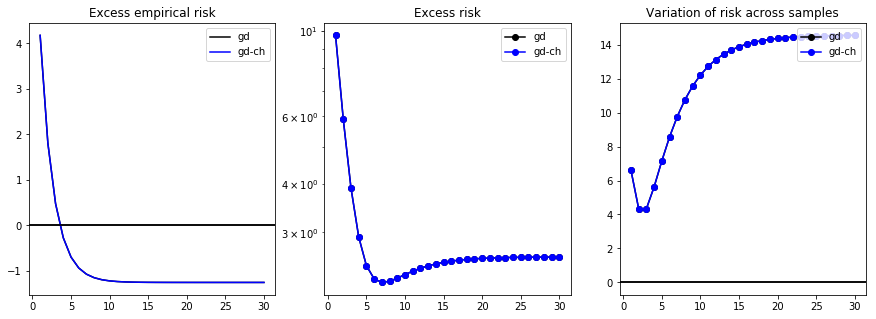

In [8]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

__練習問題__

0. 上記の具体例では、終了条件として`iter_train.epoch`を使っている。Chainerでは、epochが何をしているか説明すること。ミニバッチの大きさを$n$より小さな整数にした場合、より速く終了することを確かめること。

<a id="chainer_exNonLin"></a>
### 任意の活性化関数を用いた非線形モデル

前の節に続き、線形モデルから単純な非線形モデルへと拡張していく。入力$\mathbf{x} \in \mathbb{R}^{d_{0}}$を所与として、$\mathbf{y} = (y_{1},\ldots,y_{d_{1}})$への変換を次のように表記する。

- 線形： $y_{j} = \mathbf{w}_{j}^{T}\mathbf{x} + b_{j}$

- 非線形： $y_{j} = \phi(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j})$

これらの変換を実装した`FunctionNode`の`backward()`メソッドでは、寸法$(d_{1} \times d_{0})$のヤコビ行列$\partial \mathbf{y} / \partial \mathbf{w}$を計算し、寸法($1 \times d_{1}$)の`grad_outputs`との行列掛け算をする必要がある。ヤコビ行列自体はすぐに計算できる。線形の場合：

\begin{align*}
\frac{\partial y_{i}}{\partial w_{j,k}} =
\begin{cases}
0, & i \neq j\\
x_{k}, & i = j
\end{cases}
\end{align*}

非線形の場合も同様に：

\begin{align*}
\frac{\partial y_{i}}{\partial w_{j,k}} =
\begin{cases}
0, & i \neq j\\
\phi^{\prime}(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j}) \, x_{k}, & i = j.
\end{cases}
\end{align*}

ここで、`grad_outputs`から渡されたものを$(\gamma_{1},\ldots,\gamma_{d_{1}})$と書くことにすると、我々の`backward()`が以下の計算結果を返さなければならない。

\begin{align*}
\sum_{i=1}^{d_{1}} \gamma_{i} \frac{\partial y_{i}}{\partial w_{j,k}} = \gamma_{j} \frac{\partial y_{j}}{\partial w_{j,k}} = \gamma_{j} \, \phi^{\prime}(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j}) \, x_{k}
\end{align*}

インデックスの取る値は$j=1,\ldots,d_{1}$と$k=1,\ldots,d_{0}$である。したがって、出力するのは、容易に求められる以下のベクトルである。

\begin{align*}
\left( \gamma_{1} \, \phi^{\prime}(\mathbf{w}_{1}^{T}\mathbf{x} + b_{1}), \ldots, \gamma_{d_{1}} \, \phi^{\prime}(\mathbf{w}_{d_{1}}^{T}\mathbf{x} + b_{d_{1}}) \right).
\end{align*}

以下で非線形モデルを実装するとき、このベクトルは`gy_nl`に相当する(以前として$1 \times d_{1}$の二次元配列)。$\mathbf{b}$や$\mathbf{x}$についての偏微分もまったく同様に線形から非線形へと拡張することができる。

In [9]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import models
import dataclass

In [10]:
class NonLinearFunction(ch.function_node.FunctionNode):
    '''
    The Function object defined on Variable objects
    that is the basis for a linear transformation to
    be wrapped up as a Link object. The basic idea is
    that we have d-dimensional inputs x, and the array
    called "W" is of the shape (k, d). Thus the output
    of x.dot(W.T) is that of precisely k "units".
    '''
    
    def f_nonlin(self, u):
        '''
        Non-linear activation function.
        Here: vectorized logistic function.
        '''
        return 1 / (1+np.exp(-u))
    
    def df_nonlin(self, u):
        '''
        First-order derivative of non-linear
        activation function.
        Here: vectorized logistic function deriv.
        '''
        y = self.f_nonlin(u=u)
        return y * (1-y)
    
    def forward(self, inputs):
        '''
        Forward computation for both CPU and GPU.
        '''
        
        # Unpack the tuple of inputs.
        if len(inputs) == 3:
            x, W, b = inputs
        else:
            (x, W), b = inputs, None

        y = x.dot(W.T).astype(x.dtype, copy=False)
        
        # Add a bias term, if relevant.
        if b is not None:
            y += b
            self.retain_inputs((0,1,2))
        else:
            self.retain_inputs((0,1))
            
        # Finally the non-linear activation.
        y = self.f_nonlin(y)
        
        # Must return the output as a tuple.
        return (y,)
    

    def backward(self, indices, grad_outputs):
        '''
        Backward computation for both CPU and GPU.
        '''
        
        if len(indices)==3:
            x, W, b = self.get_retained_inputs()
        else:
            (x, W), b = self.get_retained_inputs(), ch.Variable(None)
        
        y = x.data.dot(W.data.T).astype(x.dtype, copy=False) # (n,k)
        #y, = self.forward(inputs=(x.data, W.data, b.data)) # (n,k). Needed for grad comps.
        gy, = grad_outputs # written as gamma in their docs.
        gy_nl = ch.Variable(self.df_nonlin(y)) * gy # to account for non-linearity.
        
        # Says that backward() must return a tuple, but
        # looking at their source code for linear.py, it
        # seems like lists are fine.
        out = []
        if 0 in indices:
            gx = gy_nl @ W # gy_nl.dot(W)
            out.append(ch.functions.cast(gx, x.dtype))
        if 1 in indices:
            gW = gy_nl.T @ x # gy_nl.T.dot(x)
            out.append(ch.functions.cast(gW, W.dtype))
        if 2 in indices:
            # Summing here is simple: for n observations,
            # gy has shape (n,k), where k is the number of
            # layer outputs. Summing over axis=0 is summing
            # over OBSERVATIONS, not over outputs.
            gb = ch.functions.sum(gy_nl, axis=0) # gy_nl.sum(axis=0)
            out.append(ch.functions.cast(gb, b.dtype))
            
        # Return just the relevant gradients we appended.
        return out


def nonlinear(x, W, b):
    '''
    A nice thin wrapper for our non-linear FunctionNode on
    Variable objects.
    '''
    if b is None:
        args = (x, W)
    else:
        args = (x, W, b)
        
    y, = NonLinearFunction().apply(args)
    return y

In [11]:
class NonLinear(ch.Link):
    '''
    A Link class for our non-linear transformation, implemented
    in the NonLinearFunction class.
    '''
    def __init__(self,
                 in_size, out_size,
                 init_W=None, init_b=None,
                 init_delta=None,
                 nobias=False):
        super(NonLinear, self).__init__()
        
        # Here we initialize and "register" the parameters
        # of interest. This is critical because when we
        # call __call__(x) and apply the underlying affine
        # transformations to input x (both forward pass and
        # backward pass), the optimization algorithm knows
        # that we want to optimize W and maybe b, but not x.

        with self.init_scope():
            
            # If provided an ndarray, use it.
            if init_W is not None:
                self.W = ch.Parameter(initializer=np.copy(init_W))
            
            # Else, use a built-in initializer.
            else:
                W_initializer = ch.initializers.Uniform(scale=init_delta,
                                                        dtype=np.float32)
                self.W = ch.Parameter(initializer=W_initializer,
                                      shape=(out_size, in_size))
            
            if nobias:
                self.b = None
            else:
                if init_b is not None:
                    self.b = ch.Parameter(initializer=np.copy(init_b))
                else:
                    self.b = ch.Parameter(initializer=0,
                                          shape=(out_size,))
                
    def __call__(self, x):
        '''
        This method actually applies the linear layer to
        inputs x.
        '''
        return nonlinear(x, self.W, self.b)
    

In [12]:
class Chain_NonLinReg(ch.Chain):
    '''
    A simple feed-forward neural network that has
    one hidden layer, with non-linear activation.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_W1=None,
                 init_W2=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_NonLinReg, self).__init__()
        
        with self.init_scope():
            self.l1 = NonLinear(in_size=out_l0,
                                out_size=out_l1,
                                init_W=init_W1,
                                init_b=None,
                                init_delta=init_delta,
                                nobias=True)
            
            self.l2 = models.Linear(in_size=out_l1,
                                    out_size=out_l2,
                                    init_W=init_W2,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)

    def __call__(self, x):
        out = self.l1(x)
        out = self.l2(out)
        return out
    
    
class Chain_Logistic(ch.Chain):
    '''
    For pre-built activation functions, we can just pass
    linear layers through them, and Chainer does the rest.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_W1=None,
                 init_W2=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_Logistic, self).__init__()
        
        with self.init_scope():
            
            self.l1 = models.Linear(in_size=out_l0,
                                    out_size=out_l1,
                                    init_W=init_W1,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)
            
            self.l2 = models.Linear(in_size=out_l1,
                                    out_size=out_l2,
                                    init_W=init_W2,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)
        
    def __call__(self, x):
        out = ch.functions.sigmoid(self.l1(x)) # logistic sigmoid.
        out = self.l2(out)
        return out

In [13]:
n = 3
d0, d1, d2 = 2, 4, 2

init_W1 = np.arange(d0*d1, dtype=np.float32).reshape((d1,d0))
init_W2 = np.arange(d1*d2, dtype=np.float32).reshape((d2,d1))

mod_us = Chain_NonLinReg(out_l0=d0, out_l1=d1, out_l2=d2,
                         init_W1=init_W1, init_W2=init_W2)
mod_them = Chain_Logistic(out_l0=d0, out_l1=d1, out_l2=d2,
                         init_W1=init_W1, init_W2=init_W2)

X = np.random.normal(loc=0.0, scale=1.0, size=(n,d0))

y_us = mod_us(X)
y_them = mod_them(X)

print("Outputs (us vs. them), n =", n, "samples:")
print("-----")
for i in range(n):
    print(y_us.data[i,:])
    print(y_them.data[i,:])
    print("-----")
    
# Gradient compuations.
y_us.grad = np.ones(y_us.data.shape, dtype=y_us.data.dtype)
y_them.grad = np.ones(y_them.data.shape, dtype=y_them.data.dtype)
mod_us.cleargrads()
mod_them.cleargrads()
y_us.backward()
y_them.backward()

print("Gradient comparison:")
print("--")
diff_sq = 0
zipped = zip(mod_us.params(), mod_them.params())
for p_us, p_them in zipped:
    grad_us = p_us.grad
    grad_them = p_them.grad
    diff_sq += np.linalg.norm(grad_us-grad_them)**2
    print("us:", grad_us)
    print("them:", grad_them)
    print("--")
    
print("Difference:", math.sqrt(diff_sq))

Outputs (us vs. them), n = 3 samples:
-----
[0.87012995 3.47568442]
[0.87012995 3.47568442]
-----
[0.24158042 2.7378033 ]
[0.24158042 2.7378033 ]
-----
[2.52917936 8.49487156]
[2.52917936 8.49487156]
-----
Gradient comparison:
--
us: [[ 1.2020643 -1.8916731]
 [ 2.1698744 -2.6294236]
 [ 3.217658  -3.2660933]
 [ 4.058814  -3.896445 ]]
them: [[ 1.2020643 -1.8916731]
 [ 2.1698744 -2.6294236]
 [ 3.217658  -3.2660933]
 [ 4.058814  -3.896445 ]]
--
us: [[0.9181247  0.6589377  0.58746296 0.602342  ]
 [0.9181247  0.6589377  0.58746296 0.602342  ]]
them: [[0.9181247  0.6589377  0.58746296 0.602342  ]
 [0.9181247  0.6589377  0.58746296 0.602342  ]]
--
Difference: 0.0


要点：

 - 活性化関数がChainerの`functions`モジュールに標準搭載されている場合は、わざわざ自分の`NonLinearFunction`を作る必要はなく、線形`Link`をそのまま非線形変換に渡すだけで済むのである。
 
 - 一方、Chainerにあらかじめ用意されていない活性化関数を使いたいときは、上記の段取りを模倣することで、任意の微分可能な非線形変換に対応した`Link`を整備することが容易にできる。
 

<a id="chainer_lgstreg"></a>
### 多クラスのロジスティック回帰の自作と比較

<a href="Classifiers.ipynb">前の章</a>では、自作のロジスティック回帰を用意した。ここではChainerを使ったロジスティック回帰の学習機を作る。

In [14]:
import os
import tables
import numpy as np
import chainer as ch
import multiprocessing as mltp

import dataclass
import algorithms
import helpers as hlp
import models

In [15]:
# Experimental setup.

task_name = "iris" # SET BY HAND.
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = os.path.join("data", task_name, "data.h5")
f = tables.open_file(toread, mode="r")

# Data for the hand-built model.
data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

# Data for Chainer model.
Z_tr = ch.datasets.TupleDataset(np.float32(f.root.train.inputs.read()),
                                np.int8(f.root.train.labels.read()))

In [16]:
## Experiment setup.

n, numfeats = data.X_tr.shape # sample size, number of features.
nc = 3 # number of classes
d = (nc-1)*numfeats

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 100 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.1

# Clerical.
mth_names = ["lgstReg", "lgstReg-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [17]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Initial weight settings.
    w_init = np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    W_init_ch = np.concatenate((w_init.flatten().reshape((nc-1,numfeats)),
                                np.zeros((1,numfeats), dtype=np.float32)),
                               axis=0) # add an extra row of zeros to start.
    
    # Initialize models (hand-built).
    mod_learner = models.LogisticReg(data=data)
    risk_star = 0 # lower bound on optimal risk value.
    loss_star = 0
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=numfeats,
                               out_l1=nc,
                               init_W=W_init_ch,
                               init_b=None,
                               init_delta=init_delta,
                               nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)
    
    # Initialize algorithms (Chainer-based).
    opt_chainer = ch.optimizers.SGD(lr=alphaval)
    opt_chainer.setup(mod_chainer) # pass model!

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            y_est_te = mod_learner.classify(w=al_gd.w, X=data.X_te)
            riskvals[tri,idx,mthidx] = mod_learner.class_perf(y_est=y_est_te,
                                                              y_true=data.y_te)["rate"]-risk_star
            idx += 1
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z_tr,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Get the un-normalized log-probability outputs.
            prediction_tr = mod_chainer(X_batch)
            
            #np.concatenate((mod_chainer(X_batch).data,
            #                                np.zeros((X_batch.shape[0],1), dtype=np.float32)),
            #                               axis=1) # need to append zeros for 1-probs.

            # Loss computations (will feed the grad computations).
            loss = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                      t=np.int8(data.y_tr).flatten(),
                                                      normalize=True,
                                                      reduce="mean")
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.backward()
            
            # Parameter updates.
            opt_chainer.update()
            
            # Record performance.
            loss_tr[tri,idx,mthidx] = loss.data-loss_star
            prediction_te = mod_chainer(data.X_te)
            accuracy = ch.functions.accuracy(y=prediction_te,
                                             t=np.int8(data.y_te).flatten()).data
            
            riskvals[tri,idx,mthidx] = 1.0-accuracy-risk_star
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)

一つ注目すべきは、`Chain_LinReg`をそのまま使っていることである。前の節の文脈では、このモデルを線形回帰のために整備したのだが、ロジスティック回帰に必要な演算はすべてカバーされているので、問題なく使える。回帰モデルとの違いがどこにあるかというと、今回は実数スカラーではなく、多次元ベクトルを出していることと、その出力がsoftmax cross-entropyに渡されていることである。

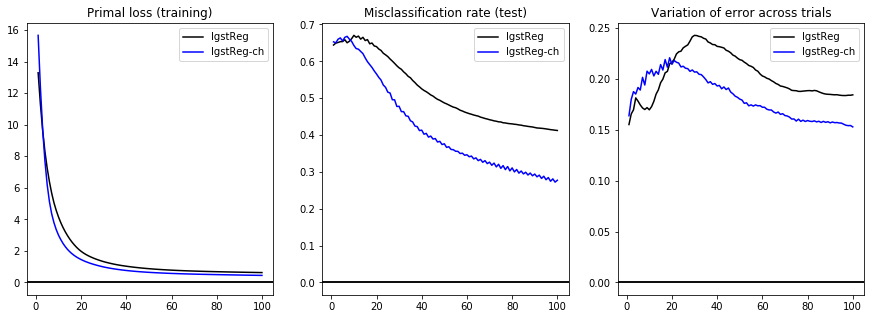

In [18]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Primal loss (training)")

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.plot(tvals, vals, "-", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Misclassification rate (test)")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of error across trials")


plt.show()

In [19]:
# Close the file connection.
f.close()

__練習問題__

0. 基本的な振る舞いが似ているとはいえ、`lgstReg`と`lgstReg-ch`がまったく同じ働きをしているわけではない。これはなぜだろうか。

<a id="chainer_newopt"></a>
### 最適化を自分の手で

これまでのChainerを用いた事例では、標準整備された`Optimizer`サブクラスを使っている。具体的には、`SGD`というサブクラスで、確率的勾配降下法を実装したものであるが、これまでの例ではミニバッチの大きさを$n$としているので、結局は決定論的な勾配降下法(GD)であった。

最適化法を自分で調整・改造したいときには、主として糸口が2つある。（１）`Optimizer`サブクラスを自分で作って、上と同様に使うこと。（２）そもそも`Optimizer`の枠組みを使わずに、モデルが管理する`Parameter`オブジェクト自体を操作すること。

前者ではCPU/GPUハードウェアを駆使することがきわめて楽であるが、自由度が比較的低く、実装できるアルゴリズムが限られてしまう。後者では、考えられる範囲でほとんど何でもできる。

#### 自力でGDを行う簡単な例

In [20]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 30 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.25

# Clerical.
mth_names = ["gd", "gd-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [21]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [22]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=d,
                          out_l1=1,
                          init_W=w_init.T,
                          init_b=None,
                          init_delta=init_delta,
                          nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_gd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_gd.w)-0
            idx += 1
        
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Predictions.
            prediction_tr = mod_chainer(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.backward()

            # Parameter updates.
            for p in mod_chainer.params():
                grad = p.grad
                if grad is None:
                    continue
                else:
                    p.data -= alphaval * grad
            
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

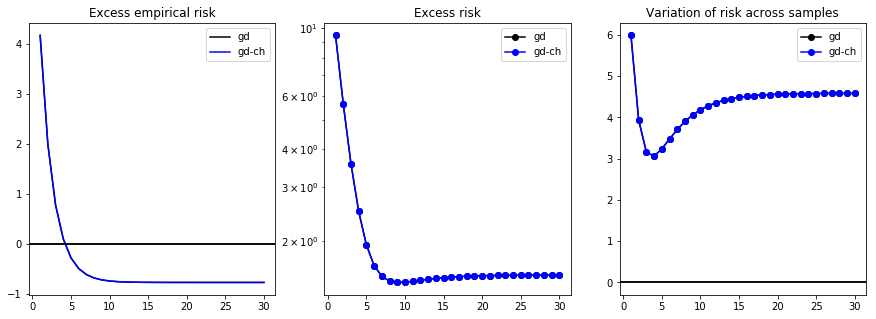

In [23]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")
    

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

__練習問題__

0. 上のコードでは決定論的な勾配降下法を`Optimizer`枠組みの外で実装した。これを踏まえて、任意のミニバッチに対応できる確率的勾配降下法（SGD)に拡張すること。また、これが事前に指定する$T$回だけ反復するようにすること（注：`iter_train.epoch`の箇所は修正が必要）。

___